# Introduction
- This script is about the preprocessing steps for the dataset used for fine-tuning T5 on the translation task of first-order logic formulas to natural sentences. (FOL2NS)

### **Catalogue**
#### Step 1: Training and Validation dataset
1. Preprocess the FOLIO dataset
#### Step 2: Generate Test dataset with the format of FOLIO
2. Defined FOL by CFG
3. Defined FOL2NW with predicates

# Step 1: Training and Validation dataset

## 1. Preprocess the FOLIO dataset
- I read the "FOLIO_train.json" and "FOLIO_validation.json" for this step
- The dataset processed in this step has been saved as a json document named "FOL2NS.json"

- The information about the FOLIO dataset
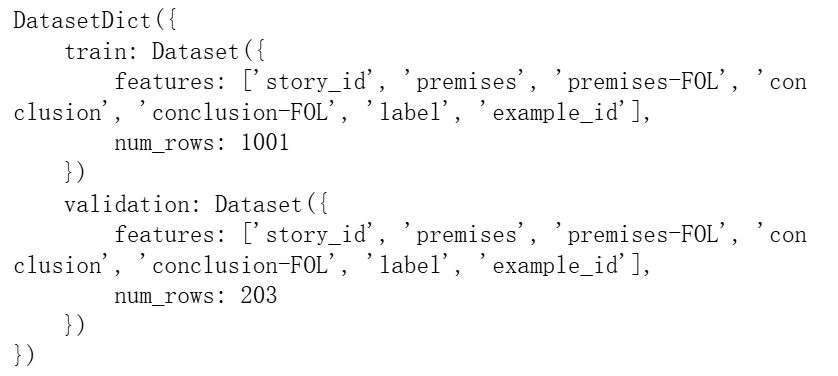

In [100]:
import pandas as pd

In [101]:
# The standard step is to load the dataset from hugging face
# but it doesn't allow me to replace the token
# So I downloaded it as two split datasets "FOLIO_train.json", "FOLIO_validation.json" 
# and directly read them for later operations.

# from huggingface_hub import login
# login(token=os.getenv("HF_TOKEN"))
# from datasets import load_dataset
# dataset = load_dataset("yale-nlp/FOLIO", repo_type="dataset", use_auth_token=True)
# df_train = pd.DataFrame(dataset['train'])
# df_validation = pd.DataFrame(dataset['validation'])

In [102]:
df_train = pd.read_json(
    "FOLIO_train.json",
    orient="records",
    lines=True
)
df_train.head(5)

,story_id,premises,premises-FOL,conclusion,conclusion-FOL,label,example_id
0,406,All people who regularly drink coffee are depe...,"∀x (DrinkRegularly(x, coffee) → IsDependentOn(...",Rina doesn't want to be addicted to caffeine o...,"¬WantToBeAddictedTo(rina, caffeine) ∨ (¬AwareT...",True,1126
1,406,All people who regularly drink coffee are depe...,"∀x (DrinkRegularly(x, coffee) → IsDependentOn(...",Rina eith doesn't want to be addicted to caffe...,"¬WantToBeAddictedTo(rina, caffeine) ⊕ ¬AwareTh...",True,1127
2,406,All people who regularly drink coffee are depe...,"∀x (DrinkRegularly(x, coffee) → IsDependentOn(...",Rina either regularly drinks coffee or is unaw...,"DrinkRegularly(rina, coffee) ⊕ IsUnawareThatC...",False,1128
3,406,All people who regularly drink coffee are depe...,"∀x (DrinkRegularly(x, coffee) → IsDependentOn(...",If Rina either doesn't want to be addicted to ...,(DoNotWantToBeAddictedToCaffeine(rina) ⊕ ¬Awar...,True,1129
4,8,Miroslav Venhoda was a Czech choral conductor ...,Czech(miroslav) ∧ ChoralConductor(miroslav) ∧ ...,Miroslav Venhoda loved music.,"Love(miroslav, music)",Uncertain,20


In [103]:
df_validation = pd.read_json(
    "FOLIO_validation.json",
    orient="records",
    lines=True
)
df_validation.head(5)

,story_id,premises,premises-FOL,conclusion,conclusion-FOL,label,example_id
0,380,People in this club who perform in school tale...,"∀x (InThisClub(x) ∧ PerformOftenIn(x, schoolTa...",Bonnie performs in school talent shows often.,"InThisClub(bonnie) ∧ (Perform(bonnie, schoolTa...",Uncertain,1014
1,380,People in this club who perform in school tale...,"∀x (InThisClub(x) ∧ PerformOftenIn(x, schoolTa...",If Bonnie is either both a young child or teen...,¬((YoungChildren(bonnie) ⊕ Teenager(bonnie)) ∧...,True,1015
2,380,People in this club who perform in school tale...,"∀x (InThisClub(x) ∧ PerformOftenIn(x, schoolTa...",If Bonnie either chaperones high school dances...,"(Chaperone(bonnie, highSchoolDance) ⊕ Perform(...",False,1016
3,426,All employees who schedule a meeting with thei...,"∀x ((Employee(x) ∧ Schedule(x, meeting, custom...",James has lunch in the company.,"HasLunch(james, company)",Uncertain,1208
4,426,All employees who schedule a meeting with thei...,"∀x ((Employee(x) ∧ Schedule(x, meeting, custom...",James does not have lunch in the company.,"¬HasLunch(james, company)",Uncertain,1209


In [104]:
def clean_dataset_conclusion(dataset, first_column, second_column):
  new_dataset = dataset[[first_column,second_column]].copy()
  new_dataset[[first_column, second_column]] = new_dataset[[second_column, first_column]].values
  newname_dataset = new_dataset.rename(columns={first_column: "input", second_column: "output"})
  df = newname_dataset.drop_duplicates().reset_index(drop=True)
  return df

In [105]:
def clean_dataset_premises(dataset, first_column, second_column):
  new_dataset = dataset[[first_column,second_column]].copy()
  new_dataset['paired_premises'] = new_dataset.apply(
      lambda row: list(zip(row[first_column].splitlines(), row[second_column].splitlines()))
      if isinstance(row[first_column], str) and isinstance(row[second_column], str)
      else [], axis=1
  )
  new_dataset = new_dataset.explode('paired_premises', ignore_index=True)
  new_dataset[[first_column, second_column]] = pd.DataFrame(new_dataset['paired_premises'].tolist(), index=new_dataset.index)
  new_dataset.drop(columns=['paired_premises'], inplace=True)
  new_dataset.drop_duplicates(subset=[first_column, second_column], inplace=True)
  new_dataset[[first_column, second_column]] = new_dataset[[second_column, first_column]].values
  newname_dataset = new_dataset.rename(columns={first_column: "input", second_column: "output"})
  df = newname_dataset.reset_index(drop=True)
  return df

In [106]:
FOL2NS_01 = clean_dataset_conclusion(df_train,'conclusion','conclusion-FOL')
FOL2NS_02 = clean_dataset_premises(df_train,'premises','premises-FOL')
FOL2NS_03 = clean_dataset_conclusion(df_validation,'conclusion','conclusion-FOL')
FOL2NS_04 = clean_dataset_premises(df_validation,'premises','premises-FOL')
FOL2NS_dataset = pd.concat([FOL2NS_01, FOL2NS_02, FOL2NS_03, FOL2NS_04], ignore_index=True)
FOL2NS_dataset

,input,output
0,"¬WantToBeAddictedTo(rina, caffeine) ∨ (¬AwareT...",Rina doesn't want to be addicted to caffeine o...
1,"¬WantToBeAddictedTo(rina, caffeine) ⊕ ¬AwareTh...",Rina eith doesn't want to be addicted to caffe...
2,"DrinkRegularly(rina, coffee) ⊕ IsUnawareThatC...",Rina either regularly drinks coffee or is unaw...
3,(DoNotWantToBeAddictedToCaffeine(rina) ⊕ ¬Awar...,If Rina either doesn't want to be addicted to ...
4,"Love(miroslav, music)",Miroslav Venhoda loved music.
...,...,...
3260,"BornIn(ailtonSilva, year1995) ∧ CommonlyKnownA...","Ailton Silva, born in 1995, is commonly known ..."
3261,"FootballPlayer(ailton) ∧ LoanedTo(ailton, braga)",Ailton is a football player who was loaned out...
3262,Brazilian(ailtonSilva) ∧ Footballplayer(ailton...,Ailton Silva is a Brazilian footballer who pla...
3263,FootballClub(nautico) ∧ FootballClub(braga),Náutico is a football club along with Braga.


In [107]:
# No longer need to save it
# Have already built the dataset as a json document named "FOL2NS.json"

# FOL2NS_dataset.to_json(
#     "FOL2NS.json",
#     orient="records",
#     lines=True,        
#     force_ascii=False
# )

In [108]:
def count_symbol_in_samples(dataset, special_token):
    sample_count = 0
    
    for sentence in dataset:
        if special_token in sentence:
            sample_count += 1
            
    return sample_count

In [109]:
special_token = "¬"
check = FOL2NS_dataset["input"]
samples_with_special_token = count_symbol_in_samples(check, special_token)
print(f"Total samples: 3265, '{special_token}' samples: {samples_with_special_token}, ratio:{(int(samples_with_special_token)/3265)*100:.2f}%")

Total samples: 3265, '¬' samples: 841, ratio:25.76%


# Step 2: Generate Test dataset with the format of FOLIO

## 2. Defined FOL by CFG
- The following section only provides the test samples
- The actual dataset in this stephas been run in advance and saved as a json document named "Defined_FOL.json"
- I read the "Defined_FOL.json" for the section "2.Defined FOL2NW with predicates"

In [31]:
import random
import re
import string
import numpy as np
import pandas as pd
import nltk
from nltk import CFG, grammar
from nltk.parse.generate import generate as nltk_generate

In [32]:
FOL_standard_grammar = CFG.fromstring("""
                E -> Quantified_E | Compound_E
                Predicate_E -> P '(' '_' ')' | '¬' P '(' '_' ')' | P'(' '_' ',' '#' ')' | '¬'P '(' '_' ',' '#' ')' 
                Quantified_E -> Quantifier_Part Predicate_E | '¬' Quantifier_E
                Quantifier_Part -> '∀' '_' | '∃' '_'
                Compound_E -> E LO E
                LO -> '∧' | '∨' | '→' | '⊕'
                P -> 'ph'
                """)

In [33]:
FOL_nested_grammar = CFG.fromstring('''
                E -> Predicate_E | Quantified_E | Compound_E
                Predicate_E -> P '(' '_' ')' | '¬' P '(' '_' ')' | P'(' '_' ',' '#' ')' | '¬'P '(' '_' ',' '#' ')'
                Quantified_E -> Quantifier_Part Predicate_E | Quantifier_Part '(' Predicate_E LO E ')' | '¬' Quantifier_E
                Quantifier_Part -> '∀' '_' | '∃' '_'
                Compound_E -> E LO E
                LO -> '∧' | '∨' | '→' | '⊕'
                P -> 'ph'
               ''')

In [34]:
def variable_appear(variable_list, used_variable):
  for var in variable_list:
    if var not in used_variable:
      used_variable.add(var)
      return var
  return None

In [35]:
def replace_placeholder(grammar, symbol, variable_list, order, used_variables):
  placeholders = grammar.count(symbol)
  step = grammar.split(symbol)
  result = step.pop(0)
  quantifier_scope = []
  variable_count = 0

  for st in step:
    if result.strip().endswith(("∀", "∃")):
      var = next((v for v in variable_list if v not in used_variables), None)
      if var is None:
        return None
      quantifier_scope.append(var)
    elif quantifier_scope:
      var = quantifier_scope[-1]
    else:
      remain_vars = [v for v in variable_list if v not in used_variables]
      var = remain_vars[0] if remain_vars else None
      if var is None:
        return None

    used_variables.add(var)
    result += var + st
    variable_count += 1

  return result

In [36]:
def generation(cfg, dataset_len=30, sample_len=5, min_depth=4, max_depth=10):
  dataset = []
  for _ in range(dataset_len):
    depth = np.random.randint(min_depth, max_depth)
    for s in nltk_generate(cfg, n=dataset_len, depth=depth):
      FOL = ' '.join(s)
      used_variables = set()

      if '_' in FOL:
        FOL = replace_placeholder(FOL, '_', list(string.ascii_lowercase), order=True, used_variables=used_variables)
        if FOL is None:
          continue
      if '#' in FOL:
        FOL = replace_placeholder(FOL, '#', list(string.ascii_lowercase), order=False, used_variables=used_variables)
        if FOL is None:
          continue
      if 'ph' in FOL:
        FOL = replace_placeholder(FOL, 'ph', list(string.ascii_uppercase), order=False, used_variables=used_variables)
        if FOL is None:
          continue

      dataset.append(FOL)

  sample_size = min(sample_len, len(dataset))
  sample = np.random.choice(dataset, sample_size, replace=False) if sample_size > 0 else dataset
  return sample

In [37]:
sample1 = generation(FOL_standard_grammar)
sample2 = generation(FOL_nested_grammar)

In [39]:
combined = np.concatenate((sample1, sample2))
Inputs = pd.DataFrame(combined, columns=['FOL']).drop_duplicates()
Defined_FOL_sample = Inputs.sample(frac=1).reset_index(drop=True)
Defined_FOL_sample

,FOL
0,∀ a ( A ( a ) ∨ ¬ B ( a ) )
1,∀ a A ( a )
2,∀ a ¬ A ( a )
3,"∀ a ( A ( a ) ∧ B ( a , b ) )"
4,"∀ a ( A ( a ) ∧ ∀ b ( B ( b ) ∧ C ( b , c ) ) )"
5,∀ a ( A ( a ) ∧ ¬ B ( a ) )
6,∀ a ( A ( a ) ∧ ∀ b ( B ( b ) ∧ ∀ c C ( c ) ) )
7,∀ a A ( a ) ∨ ∀ b ¬ B ( b )


In [10]:
# No longer need to save it
# Have already built the dataset as a json document named "Defined_FOL.json"

# Defined_FOL.to_json(
#     "Defined_FOL.json",
#     orient="records",
#     lines=True,        
#     force_ascii=False
# )

## 3. Defined FOL2NW with predicates
- I read the "Defined_FOL.json" for this step
- The dataset processed in this step has been saved as a json document named "FOL2NW_with_predicate.json"
- I use "FOL2NW_with_predicate.json" for fine-tuning T5 model later

In [66]:
import re
import random
import numpy as np
import pandas as pd
import os

In [41]:
Defined_FOL = pd.read_json(
                "Defined_FOL.json",
                orient="records",
                lines=True
                )
Defined_FOL

,Inputs
0,"∀ a ( A ( a ) ∧ ∀ b B ( b ) ⊕ ∃ c C ( c , d ) )"
1,"∀ a ( ¬ A ( a ) ⊕ ¬ B ( a , b ) ∨ ¬ C ( a , c ) )"
2,"∀ a ( A ( a ) → ∀ b ( ¬ B ( b , c ) ∨ ¬ C ( b ..."
3,∀ a A ( a ) → ∀ b ¬ B ( b ) ∧ ∀ c ¬ C ( c )
4,"∀ a ( A ( a ) ∧ ∃ b ( ¬ B ( b ) ∨ ∃ c C ( c , ..."
...,...
3066,"∀ a ( A ( a ) ⊕ ∀ b ( ¬ B ( b ) ∧ C ( b , c ) ) )"
3067,∀ a ( A ( a ) → ∀ b ( B ( b ) ⊕ ∀ c C ( c ) ) )
3068,"A ( a ) ∨ B ( b , c )"
3069,"∀ a ( A ( a ) ∨ ∀ b ( ¬ B ( b , c ) ⊕ ¬ C ( b ..."


In [42]:
predicates = [

    ("IsHappy", "is happy", ["Person"]),
    ("IsSad", "is sad", ["Person"]),
    ("IsActive", "is active", ["Person"]),
    ("IsStudent", "is a student", ["Person"]),
    ("IsDoctor", "is a doctor", ["Person"]),
    ("IsArtist", "is an artist", ["Person"]),
    ("IsTired", "is tired", ["Person"]),
    ("IsHungry", "is hungry", ["Person"]),
    ("IsBusy", "is busy", ["Person"]),
    ("IsCalm", "is calm", ["Person"]),
    ("IsAngry", "is angry", ["Person"]),
    ("IsExcited", "is excited", ["Person"]),
    ("IsHealthy", "is healthy", ["Person"]),
    ("IsSick", "is sick", ["Person"]),
    ("IsCreative", "is creative", ["Person"]),
    ("IsThoughtful", "is thoughtful", ["Person"]),
    ("IsInnovative", "is innovative", ["Person"]),
    ("IsFriendly", "is friendly", ["Person"]),
    ("IsPolite", "is polite", ["Person"]),
    ("IsRude", "is rude", ["Person"]),
    ("IsGenerous", "is generous", ["Person"]),
    ("IsRich", "is rich", ["Person"]),
    ("IsPoor", "is poor", ["Person"]),
    

    ("IsFresh", "is fresh", ["Drink"]),
    ("IsCold", "is cold", ["Drink"]),
    ("IsHot", "is hot", ["Drink"]),
    ("IsBitter", "is bitter", ["Drink"]),
    ("IsSweet", "is sweet", ["Drink"]),
    

    ("IsUrban", "is urban", ["Location"]),
    ("IsRural", "is rural", ["Location"]),
    ("IsSpacious", "is spacious", ["Location"]),
    ("IsCrowded", "is crowded", ["Location"]),
    

    ("Likes", "likes", ["Person", "Person"]),
    ("Dislikes", "dislikes", ["Person", "Person"]),
    ("Admires", "admires", ["Person", "Person"]),
    ("Follows", "follows", ["Person", "Person"]),
    ("Trusts", "trusts", ["Person", "Person"]),
    ("Compliments", "compliments", ["Person", "Person"]),
    ("Recommends", "recommends", ["Person", "Person"]),
    ("Mentors", "mentors", ["Person", "Person"]),
    ("CooperatesWith", "cooperates with", ["Person", "Person"]),
    ("Inspires", "inspires", ["Person", "Person"]),
    
    ("Adopts", "adopts", ["Person", "Animal"]),
    ("Pets", "pets", ["Person", "Animal"]),
    ("Feeds", "feeds", ["Person", "Animal"]),
    ("Trains", "trains", ["Person", "Animal"]),
    
    ("Studies", "studies", ["Person", "Field"]),
    ("Enjoys", "enjoys", ["Person", "Field"]),
    ("Uses", "uses", ["Person", "Object"]),
    ("Owns", "owns", ["Person", "Object"]),
    ("Drives", "drives", ["Person", "Object"]),
    ("Wears", "wears", ["Person", "Object"]),
    ("Visits", "visits", ["Person", "Location"]),
    ("TravelsTo", "travels to", ["Person", "Location"]),
    ("Explores", "explores", ["Person", "Location"]),
    ("LivesIn", "lives in", ["Person", "Location"]),
    
    ("IsBasedIn", "is based in", ["Organization", "Location"]),
    ("OperatesIn", "operates in", ["Organization", "Location"]),
    ("HasOfficeIn", "has an office in", ["Organization", "Location"]),
    ("Produces", "produces", ["Organization", "Object"]),
    ("Buys", "buys", ["Organization", "Object"]),
    ("Sells", "sells", ["Organization", "Object"]),
    ("Develops", "develops", ["Organization", "Object"]),
    ("Publishes", "publishes", ["Organization", "Object"]),
    
    ("PartnersWith", "partners with", ["Organization", "Organization"]),
    ("MergesWith", "merges with", ["Organization", "Organization"]),
    ("CompetesWith", "competes with", ["Organization", "Organization"]),
    ("InvestsIn", "invests in", ["Organization", "Organization"]),
    ("Sponsors", "sponsors", ["Organization", "Organization"]),
    ("Regulates", "regulates", ["Organization", "Organization"]),
    
    ("Hires", "hires", ["Organization", "Person"]),
    ("Advises", "advises", ["Organization", "Person"]),
    ("Endorses", "endorses", ["Organization", "Person"]),
    ("Awards", "awards", ["Organization", "Person"]),
    
    ("IsRecognizedBy", "is recognized by", ["Organization", "Country"]),
    
    ("Chases", "chases", ["Animal", "Animal"]),
    ("Roams", "roams in", ["Animal", "Location"]),
    ("Fights", "fights with", ["Animal", "Animal"]),
    ("Observes", "observes", ["Animal", "Location"]),
    
    ("SpecializesIn", "specializes in", ["Person", "Field"]),
    ("Influences", "influences", ["Person", "Person"])
]

In [43]:
entities = { 
    "Person": [
        "person", "man", "woman", "girl", "boy", "employee", "student", "doctor", "teacher", "manager",
        "athlete", "parent", "customer", "citizen", "executive", "artist",
        "scientist", "engineer", "developer", "writer", "singer", "actor",
        "entrepreneur", "researcher", "president", "minister", "professor",
        "lawyer", "journalist", "nurse", "pilot", "chef", "driver", "designer",
        "architect", "dancer", "photographer", "soldier", "veteran", "activist",
        "consultant", "advisor", "coach", "clerk", "officer", "salesperson",
        "trader", "investor", "analyst", "planner", "strategist", "specialist",
        "mentor", "trainee", "assistant", "supervisor"
    ],
    "Organization": [
        "company", "university", "hospital", "bank", "team", "government",
        "institution", "startup", "nonprofit", "agency", "club", "society",
        "association", "corporation", "firm", "institute", "college", "bureau",
        "charity", "foundation", "coalition", "enterprise", "trading company",
        "consulting firm", "research center", "laboratory", "studio", "branch",
        "division", "department", "office", "committee", "consortium"
    ],
    "Location": [
        "city", "country", "village", "park", "region", "state", "province",
        "district", "area", "neighborhood", "suburb", "continent", "landmark",
        "island", "port", "town", "locale", "zone", "territory"
    ],
    "Field": [
        "computer science", "philosophy", "economics", "engineering", "law",
        "medicine", "biology", "chemistry", "physics", "history", "literature",
        "psychology", "sociology", "political science", "mathematics", "art",
        "music", "business", "management", "geography", "statistics", "geology",
        "linguistics", "anthropology"
    ],
    "Object": [
        "car", "book", "product", "computer", "phone", "bicycle", "tablet",
        "furniture", "instrument", "device", "machine", "tool", "gadget",
        "vehicle", "appliance", "camera", "watch", "printer", "scanner", "router"
    ],
    "Animal": [
        "dog", "cat", "bird", "penguin", "elephant", "lion", "tiger", "bear",
        "wolf", "giraffe", "zebra", "monkey", "rabbit", "squirrel", "hamster",
        "cow", "sheep", "goat", "horse", "donkey", "camel", "koala", "kangaroo",
        "alligator", "crocodile"
    ],
    "Drink": [
        "water", "coffee", "tea", "soda", "juice", "milk", "beer", "wine", "cocktail", "smoothie"
    ]
}

In [44]:
def build_predicate_mapping_for_formula(formula, predicates):
    letters = set(re.findall(r'([A-Z])\s*\(', formula))
    letter_map = {}
    for letter in letters:
        chosen_pred = random.choice(predicates)
        letter_map[letter] = (chosen_pred[0], chosen_pred[2])
    return letter_map

In [45]:
def extract_variable_types(formula, predicate_mapping):
    var_type_map = {}
    pattern = r'([A-Z])\s*\(\s*([^)]*)\s*\)'
    for match in re.finditer(pattern, formula):
        letter = match.group(1)
        args_str = match.group(2)
        if letter not in predicate_mapping:
            continue
        param_types = predicate_mapping[letter][1]
        arg_vars = [x.strip() for x in args_str.split(',') if x.strip()]
        for i, var in enumerate(arg_vars):
            if i < len(param_types):
                var_type_map[var] = param_types[i]
    return var_type_map

In [46]:
def get_first_quantified_variable(formula):
    m = re.search(r'[∀∃]\s+([a-z]+)', formula)
    if m:
        return m.group(1).strip()
    return None

In [47]:
def build_variable_mapping(var_type_map, entities, first_var):
    var_entity_map = {}
    used_entities = set()
    for var, var_type in var_type_map.items():
        if var == first_var:
            var_entity_map[var] = var
            continue
        candidates = entities.get(var_type, [])
        if candidates:
            unused = [c for c in candidates if c not in used_entities]
            if unused:
                chosen = random.choice(unused)
            else:
                chosen = random.choice(candidates)
            used_entities.add(chosen)
            var_entity_map[var] = chosen
        else:
            var_entity_map[var] = f"{var_type}_0"
    return var_entity_map

In [48]:
def replace_quantifiers(formula, var_entity_map):
    def repl(m):
        quant = m.group(1)       
        var = m.group(2).strip()  
        return quant + " " + var_entity_map.get(var, var)
    
    return re.sub(r'([∀∃])\s+([a-z]+)', repl, formula)

In [49]:
def replace_predicates(formula, predicate_mapping, var_entity_map):
    pattern = r'([A-Z])\s*\(\s*([^)]*)\s*\)'
    def repl(m):
        letter = m.group(1)
        args_str = m.group(2)
        pred_name = predicate_mapping.get(letter, (letter, []))[0]
        arg_vars = [x.strip() for x in args_str.split(',') if x.strip()]
        replaced_args = [var_entity_map.get(v, v) for v in arg_vars]
        return f"{pred_name}({', '.join(replaced_args)})"
    return re.sub(pattern, repl, formula)

In [50]:
def process_formula(formula, predicates, entities):
    predicate_mapping = build_predicate_mapping_for_formula(formula, predicates)
    var_type_map = extract_variable_types(formula, predicate_mapping)
    first_var = get_first_quantified_variable(formula)
    var_entity_map = build_variable_mapping(var_type_map, entities, first_var)
    new_formula = replace_quantifiers(formula, var_entity_map)
    new_formula = replace_predicates(new_formula, predicate_mapping, var_entity_map)
    return new_formula

In [51]:
def fol_to_natural_world(predicates, entities, formulas):
    results = []
    for formula in formulas:
        new_formula = process_formula(formula, predicates, entities)
        results.append(new_formula)
    return results

In [52]:
def result(df):
    formulas = df["Inputs"].tolist() 
    outputs = fol_to_natural_world(predicates, entities, formulas)
    df["FOL2NW"] = outputs
    return df

In [53]:
FOL2NW_with_predicate = result(Defined_FOL)
FOL2NW_with_predicate.rename(columns={"Inputs": "FOL"}, inplace=True)
FOL2NW_with_predicate

,FOL,FOL2NW
0,"∀ a ( A ( a ) ∧ ∀ b B ( b ) ⊕ ∃ c C ( c , d ) )",∀ a ( Chases(a) ∧ ∀ coach Drives(coach) ⊕ ∃ te...
1,"∀ a ( ¬ A ( a ) ⊕ ¬ B ( a , b ) ∨ ¬ C ( a , c ) )","∀ a ( ¬ SpecializesIn(a) ⊕ ¬ IsBasedIn(a, cont..."
2,"∀ a ( A ( a ) → ∀ b ( ¬ B ( b , c ) ∨ ¬ C ( b ...","∀ a ( IsSick(a) → ∀ monkey ( ¬ Drives(monkey, ..."
3,∀ a A ( a ) → ∀ b ¬ B ( b ) ∧ ∀ c ¬ C ( c ),∀ a Feeds(a) → ∀ institute ¬ Awards(institute)...
4,"∀ a ( A ( a ) ∧ ∃ b ( ¬ B ( b ) ∨ ∃ c C ( c , ...",∀ a ( Wears(a) ∧ ∃ citizen ( ¬ IsPoor(citizen)...
...,...,...
3066,"∀ a ( A ( a ) ⊕ ∀ b ( ¬ B ( b ) ∧ C ( b , c ) ) )",∀ a ( Drives(a) ⊕ ∀ smoothie ( ¬ IsDoctor(smoo...
3067,∀ a ( A ( a ) → ∀ b ( B ( b ) ⊕ ∀ c C ( c ) ) ),∀ a ( LivesIn(a) → ∀ planner ( IsSad(planner) ...
3068,"A ( a ) ∨ B ( b , c )",HasOfficeIn(department) ∨ PartnersWith(laborat...
3069,"∀ a ( A ( a ) ∨ ∀ b ( ¬ B ( b , c ) ⊕ ¬ C ( b ...",∀ a ( Buys(a) ∨ ∀ photographer ( ¬ Drives(phot...


In [54]:
# No longer need to save it
# Have already built the dataset as a json document named "FOL2NW_with_predicate.json"

# FOL2NW_with_predicate.to_json(
#     "FOL2NW_with_predicate.json",
#     orient="records",
#     lines=True,        
#     force_ascii=False
# )